<a href="https://colab.research.google.com/github/betelgeus/ABC_detection/blob/master/ABC_Classification_Pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Requirements

In [1]:
!pip install -q -U ultralytics
!pip install -q split-folders

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 605.6/605.6 kB 4.3 MB/s eta 0:00:00


In [18]:
# only for colab
!apt install subversion &>/dev/null

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Install libraries

In [3]:
import torch
import splitfolders
from pathlib import Path
import matplotlib.pyplot as plt
import cv2
import os

In [4]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE

'cuda'

### Dataload

In [19]:
# https://stackoverflow.com/questions/7106012/download-a-single-folder-or-directory-from-a-github-repo/18194523
!svn checkout https://github.com/OlgaBelitskaya/data/trunk/zip_letters ./zip_letters &>/dev/null

In [20]:
WRITTEN_LETTERS_PATH = "./zip_letters/"
WRITTEN_LETTERS = list(Path(WRITTEN_LETTERS_PATH).glob("**/*.zip"))
WRITTEN_LETTERS = list(filter(lambda x: not x.name.startswith("."), WRITTEN_LETTERS))
WRITTEN_LETTERS = list(sorted(WRITTEN_LETTERS))
print("Number of archives:", len(WRITTEN_LETTERS))

Number of archives: 66


In [21]:
!mkdir -p ./data/letters/

In [22]:
for arch in WRITTEN_LETTERS:
  !unzip -q $arch -d ./data/letters/

In [23]:
!rm -r /content/data/letters/__MACOSX

In [24]:
IMAGE_PATH = './data/letters/'
LIST_DIR = os.listdir(IMAGE_PATH)

In [25]:
for dir in LIST_DIR:
  os.rename(os.path.join(IMAGE_PATH, dir), os.path.join(IMAGE_PATH, dir[:5]))

In [26]:
!unzip /content/drive/MyDrive/data/Cyrillic_2.zip -d ./data/letters/ &>/dev/null

In [27]:
!rm -r /content/data/letters/__MACOSX

### Preprocessing

In [28]:
def make_background(image_path):
    file_without_extension = image_path.split('.')[0]
    image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
    trans_mask = image[:, :, 3] == 0
    image[trans_mask] = [255, 255, 255, 255]
    new_img = cv2.cvtColor(image, cv2.COLOR_BGRA2BGR)
    cv2.imwrite(file_without_extension + '_1.png', new_img)
    os.remove(image_path)

In [29]:
PRINTED_LETTERS_PATH = "/content/data/Cyrillic"
PRINTED_LETTERS = list(Path(PRINTED_LETTERS_PATH).glob("**/*.png"))

In [ ]:
PRINTED_LETTERS_DIR = sorted(os.listdir(IMAGE_PATH))

In [32]:
PRINTED_LETTERS_DIR = PRINTED_LETTERS_DIR[-33:]

In [33]:
for dir in PRINTED_LETTERS_DIR:
  files = list(Path(IMAGE_PATH + dir).glob("**/*.png"))
  for fl in files:
    make_background(str(fl))

In [34]:
splitfolders.ratio("/content/data/letters/", output="/content/data/letters/split",
    seed=42, ratio=(.95, .05))

Copying files: 72860 files [00:11, 6510.14 files/s]


### Model

In [5]:
from ultralytics import YOLO

In [73]:
model = YOLO('yolov8n-cls.pt')

### Train

In [ ]:
# https://github.com/ultralytics/ultralytics/blob/main/ultralytics/cfg/default.yaml
# https://rumn.medium.com/yolo-data-augmentation-explained-turbocharge-your-object-detection-model-94c33278303a

In [39]:
model.train(
    data='/content/data/letters/split',
    pretrained=True,
    epochs=20,
    imgsz=224,
    fliplr=0,
    flipud=0.0,
    translate=0.1,
    scale=0.2,
    degrees=0.05,
    shear=0.01,
    perspective=0.05,
    device=DEVICE)

Ultralytics YOLOv8.0.145 🚀 Python-3.10.6 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=classify, mode=train, model=yolov8n-cls.pt, data=/content/data/letters/split, epochs=20, patience=50, batch=16, imgsz=224, save=True, save_period=-1, cache=False, device=cuda, workers=8, project=None, name=None, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, line_width=None, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscript, keras=False, optimize=False, int8=False, dynam

### Val

In [40]:
model = YOLO('/content/runs/classify/train3/weights/best.pt')

In [41]:
metrics = model.val()

Ultralytics YOLOv8.0.145 🚀 Python-3.10.6 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8n-cls summary (fused): 73 layers, 1561699 parameters, 0 gradients
               classes   top1_acc   top5_acc: 100%|██████████| 231/231 [00:10<00:00, 21.39it/s]
                   all      0.996          1
Speed: 0.2ms preprocess, 1.1ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs/classify/val


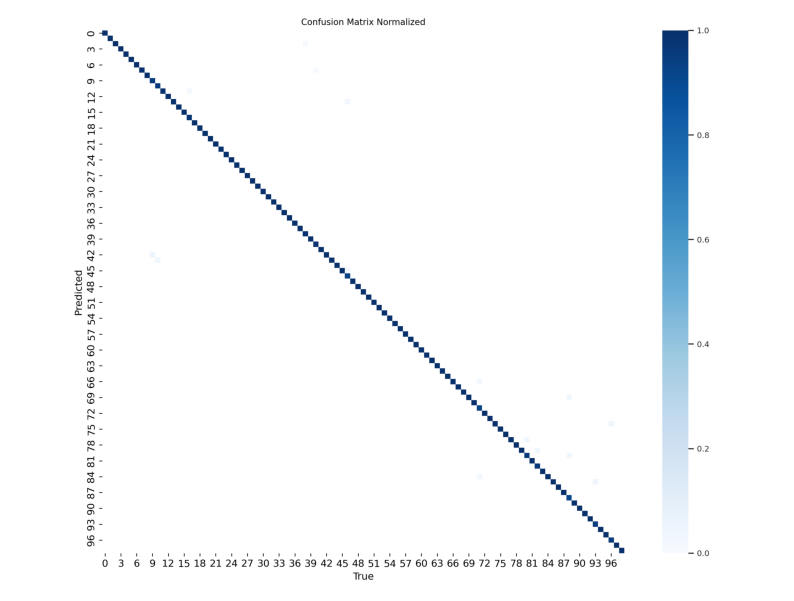

In [54]:
cnf_matrix = cv2.imread("/content/runs/classify/val/confusion_matrix_normalized.png")
cnf_matrix = cv2.cvtColor(cnf_matrix, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(cnf_matrix);

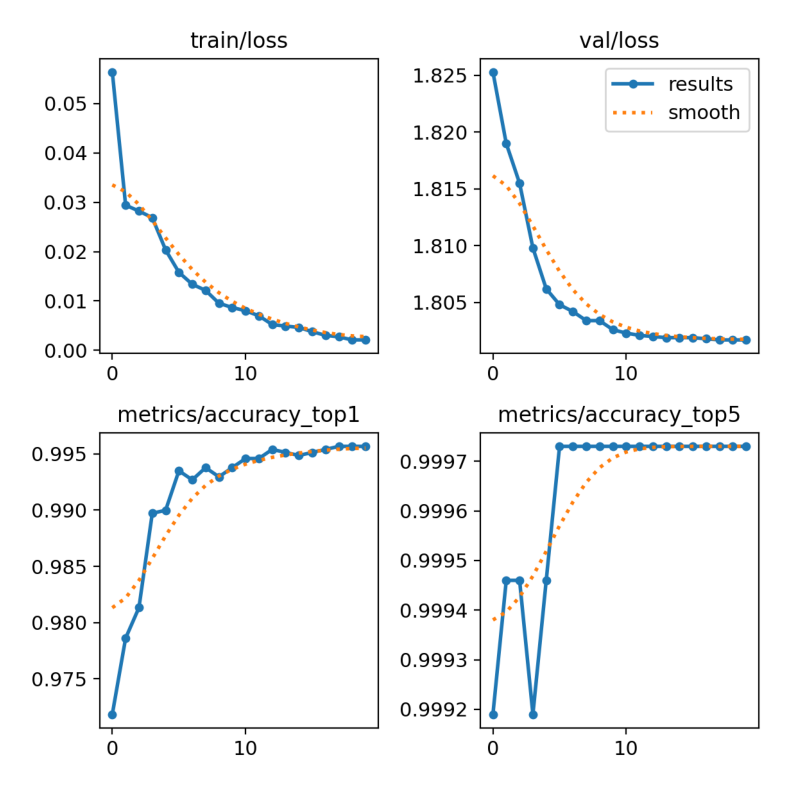

In [58]:
loss_and_accuracy = cv2.imread("/content/runs/classify/train3/results.png")
loss_and_accuracy = cv2.cvtColor(loss_and_accuracy, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(loss_and_accuracy);

### Predict

In [43]:
result = model('/content/data/letters/split/val/01_28/01_28_00_0006.png', device=DEVICE)


image 1/1 /content/data/letters/split/val/01_28/01_28_00_0006.png: 224x224 01_28 1.00, 02_28 0.00, 00_28 0.00, 01_32 0.00, 01_27 0.00, 3.4ms
Speed: 2.7ms preprocess, 3.4ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)


In [44]:
lower_case = 'абвгдеёжзийклмнопрстуфхцчшщъыьэюя'
upper_case = 'АБВГДЕЁЖЗИЙКЛМНОПРСТУФХЦЧШЩЪЫЬЭЮЯ'

mapping_abc = {}

for k, v in zip(range(33), lower_case):
    if k < 10:
        mapping_abc['00_0'+str(k)] = v
    else:
        mapping_abc['00_'+str(k)] = v


upper_case_dict = {}

for k, v in zip(range(33), upper_case):
    if k < 10:
        upper_case_dict['01_0'+str(k)] = v
    else:
        upper_case_dict['01_'+str(k)] = v


printed_dict = {}

for k, v in zip(range(33), upper_case):
    if k < 10:
        printed_dict['02_0'+str(k)] = v
    else:
        printed_dict['02_'+str(k)] = v


mapping_abc.update(upper_case_dict)
mapping_abc.update(printed_dict)

In [ ]:
index = int(torch.argmax(result[0].probs.data.to('cpu')))

In [49]:
letter = result[0].names[index]
letter

'01_28'

In [50]:
mapping_letter = mapping_abc[letter]
mapping_letter

'Ы'

In [53]:
index = int(torch.argmax(result[0].probs.data.to('cpu')))
letter = result[0].names[index]
mapping_letter = mapping_abc[letter]
mapping_letter.lower()

'ы'

In [52]:
probs = result[0].probs.data[index].to('cpu')
probs

tensor(1.0000)